In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
df_train = pd.read_csv('/content/drive/My Drive/LSTM-Multivariate_pollution.csv')
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [33]:
df_test = pd.read_csv("/content/drive/My Drive/pollution_test_data1.csv")
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [34]:
# Checking null values
print(df_train.isnull().sum() , "\n---------------- \n" , df_test.isnull().sum() )

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64 
---------------- 
 dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64


In [35]:
df_train.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


*Data vislualization and Feature Scaling*

In [36]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

# Define the mapping dictionary
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# Replace the string values with numerical values
df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# Resetting the index
df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


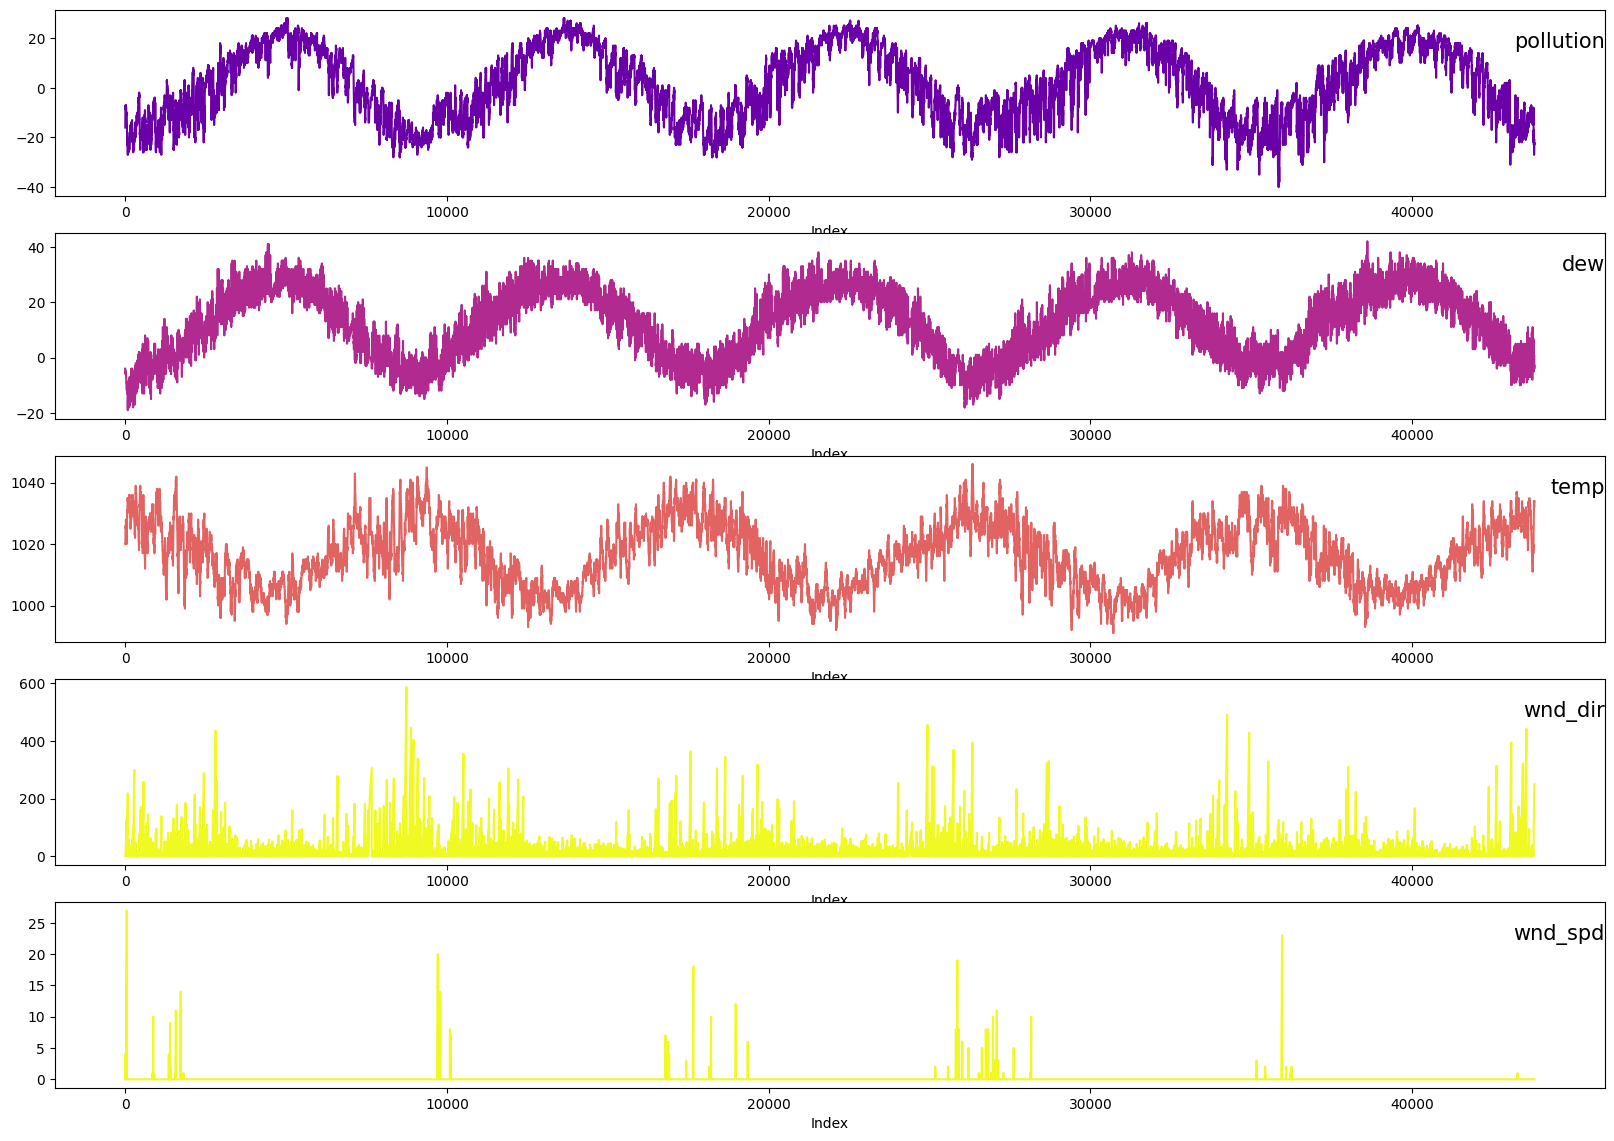

In [12]:
values = df_train_scaled.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
    plt.xlabel('Index')
    plt.title(df_train.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

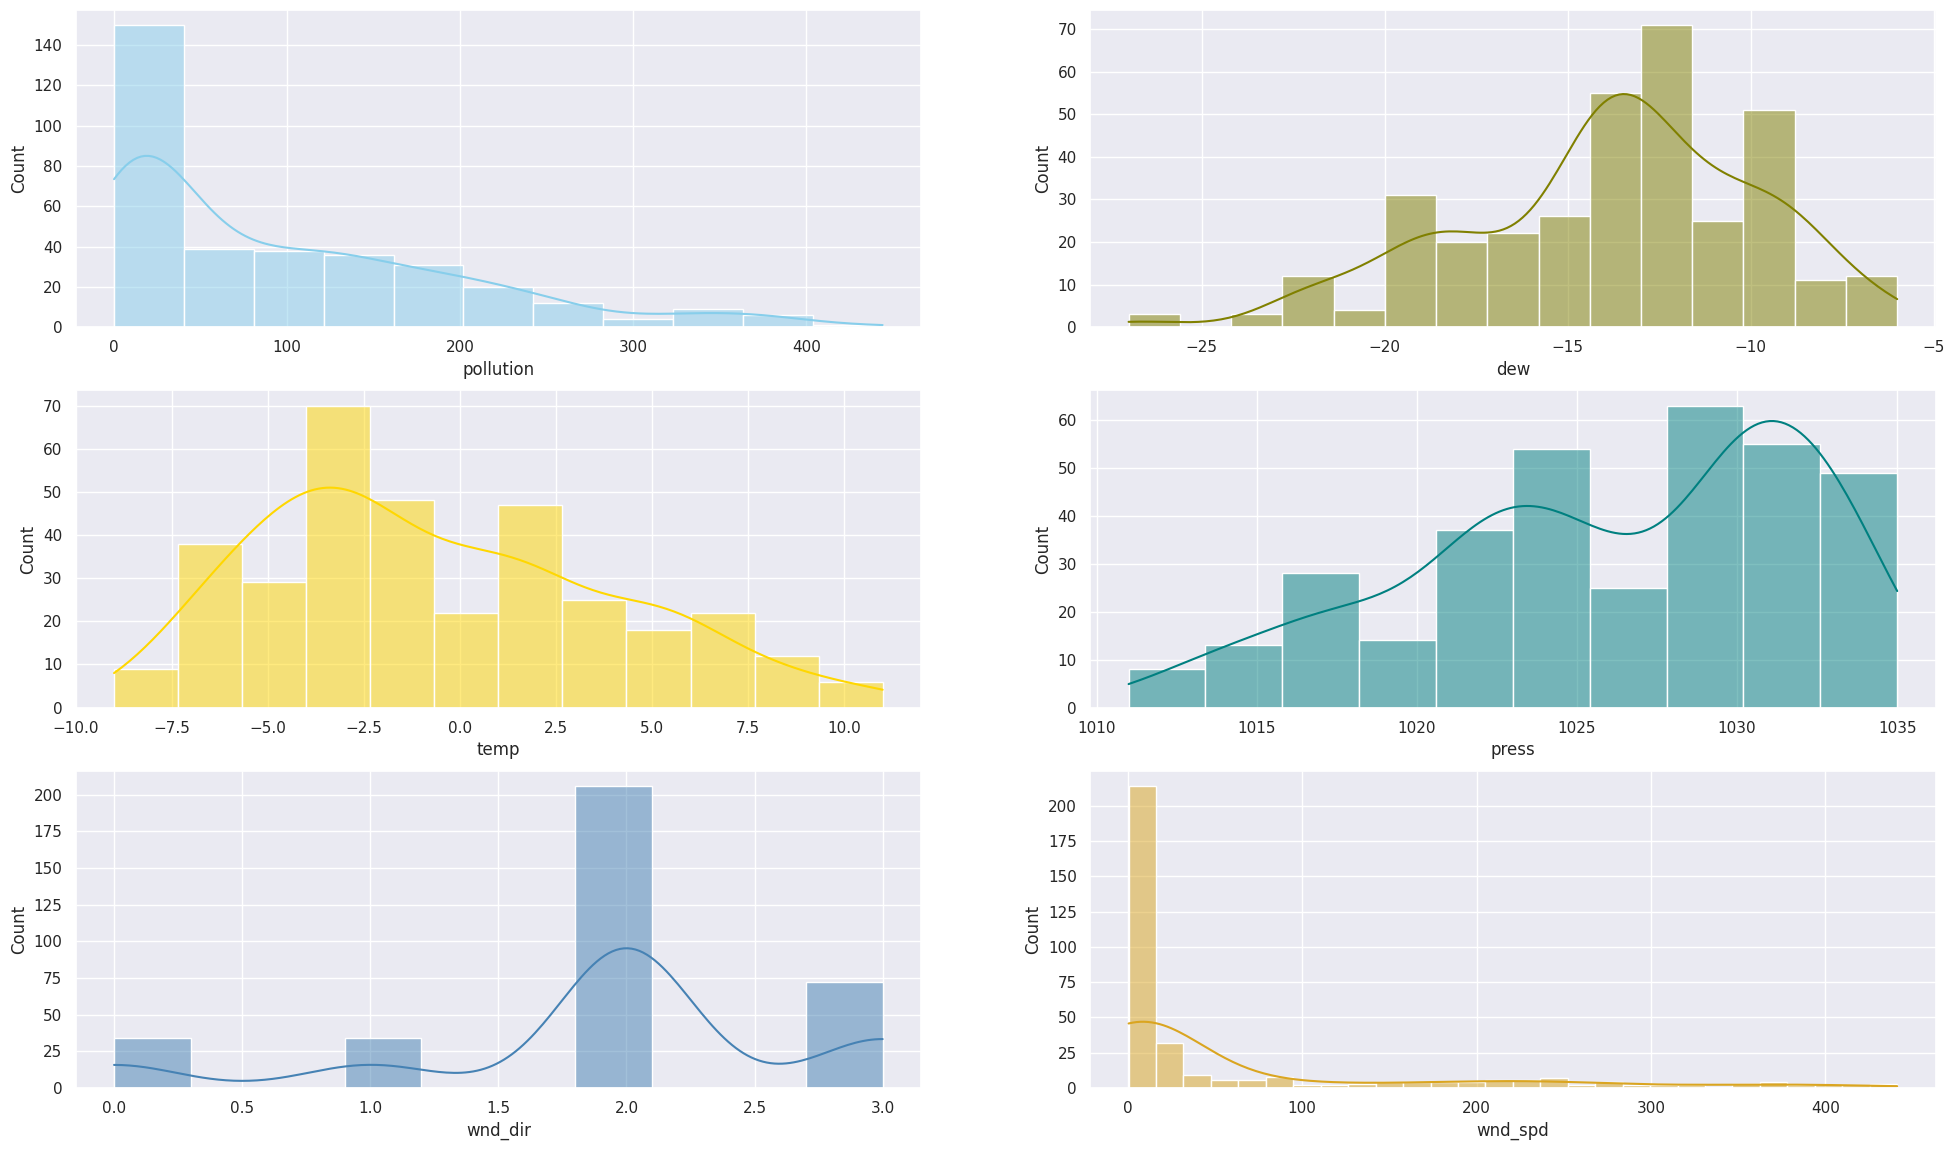

In [13]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3,2, figsize=(24,14))

sns.histplot(data=df_test_scaled, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_test_scaled, x="dew", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_test_scaled, x="temp", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df_test_scaled, x="press", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_test_scaled, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
sns.histplot(data=df_test_scaled, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])

plt.show()

In [28]:
scaler = MinMaxScaler()

# Define the columns to scale
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])

df_test_scaled = df_test_scaled[columns]

# Scale the selected columns to the range 0-1
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

# Show the scaled data
df_train_scaled.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [16]:
df_test_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.128773,0.352941,0.377049,0.654545,0.333333,0.005349,0.0,0.0
1,0.077465,0.338235,0.393443,0.654545,0.333333,0.012219,0.0,0.0
2,0.065392,0.352941,0.377049,0.654545,0.333333,0.015278,0.0,0.0
3,0.079477,0.352941,0.327869,0.672727,1.000000,0.000752,0.0,0.0
4,0.093561,0.382353,0.311475,0.672727,0.000000,0.002290,0.0,0.0


from matplotlib import pyplot as plt
_df_0['pollution'].plot(kind='hist', bins=20, title='pollution')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['dew'].plot(kind='hist', bins=20, title='dew')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['temp'].plot(kind='hist', bins=20, title='temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['press'].plot(kind='hist', bins=20, title='press')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='pollution', y='dew', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='dew', y='temp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='temp', y='press', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='press', y='wnd_dir', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['press']
  ys = series['pollution']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('press', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('press')
_ = plt.ylabel('pollution')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['press']
  ys = series['dew']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('press', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('press')
_ = plt.ylabel('dew')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['press']
  ys = series['temp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('press', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('press')
_ = plt.ylabel('temp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['press']
  ys = series['wnd_dir']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('press', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('press')
_ = plt.ylabel('wnd_dir')

from matplotlib import pyplot as plt
_df_12['pollution'].plot(kind='line', figsize=(8, 4), title='pollution')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['dew'].plot(kind='line', figsize=(8, 4), title='dew')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['temp'].plot(kind='line', figsize=(8, 4), title='temp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['press'].plot(kind='line', figsize=(8, 4), title='press')
plt.gca().spines[['top', 'right']].set_visible(False)

**Split the data into training and test sets**

In [17]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X = []
y = []
n_future = 1
n_past = 11

#  Train Sets
for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

#  Test Sets

X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape : (43789, 11, 7)   y_train shape : (43789, 1) 
X_test shape : (335, 11, 7)      y_test shape : (335, 1) 


**Create a LSTM model**

In [19]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 11, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,273 (32.32 KB)

 Trainable params: 8,273 (32.32 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# fit network
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0088 - root_mean_squared_error: 0.0934 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 2/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 3/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 5/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 6/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 7/150
1232/1232 ━

**Evaluate the Model**

In [22]:
# Load the best model
best_model = load_model('best_model.keras')

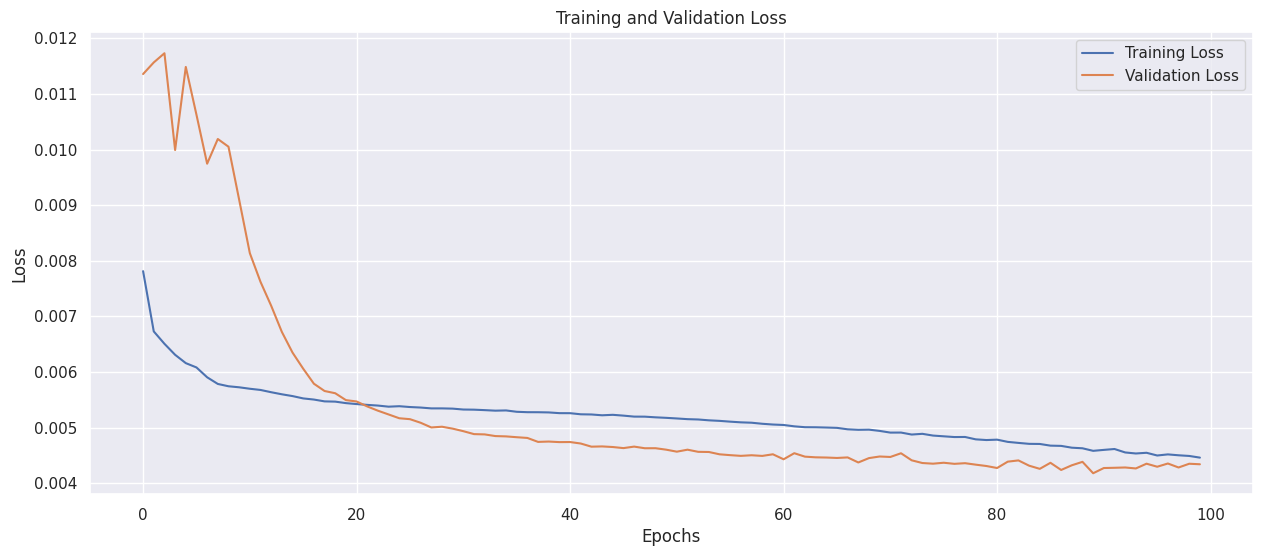

In [23]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


,Train Predictions,Actual
0,0.085799,0.171026
1,0.085911,0.160966
2,0.110520,0.146881
3,0.128541,0.125755
4,0.093579,0.130785


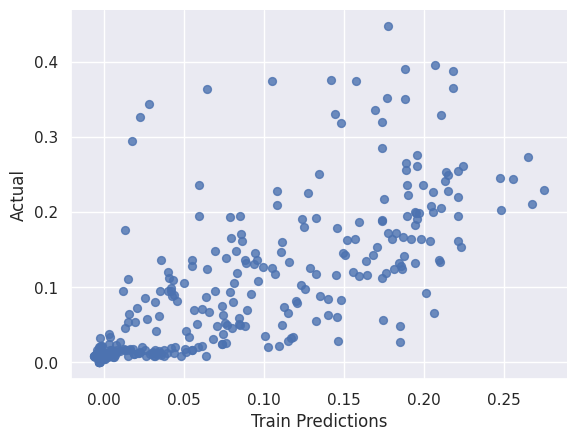

In [27]:
# @title Train Predictions vs Actual

from matplotlib import pyplot as plt
test_results.plot(kind='scatter', x='Train Predictions', y='Actual', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

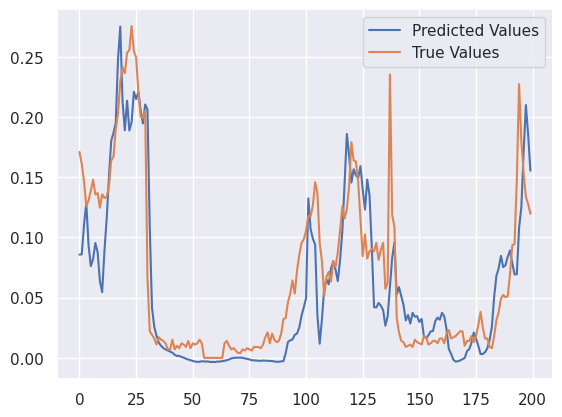

In [25]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [26]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.06882
